In [62]:
#Replication Project Code

In [63]:
import pandas as pd

In [64]:
data = pd.read_stata("Downloads/AER20090377_FinalData.dta")

In [65]:
neighbor_data = pd.read_stata("Downloads/112465-V1/AER20090377_DataAndPrograms/AER20090377_NeighborData.dta")

data.head()

,state_code,county_code,site_id,valid,epa_8hr,ozone_max,day,month,year,Date,...,Snow,EstTempFlagprcp,NumOffMax,NumOffMin,NumOff1Max,NumOff1Min,NOtherStationprcp,_merge,urban,_mergeurb
0,1,1,3,7.0,0.054250,0.068,1.0,9.0,1989.0,1989-09-01,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,3
1,1,1,3,3.0,0.020500,0.036,2.0,9.0,1989.0,1989-09-02,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,3
2,1,1,3,12.0,0.070125,0.079,3.0,9.0,1989.0,1989-09-03,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,3
3,1,1,3,12.0,0.053875,0.059,4.0,9.0,1989.0,1989-09-04,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,3
4,1,1,3,12.0,0.059125,0.065,5.0,9.0,1989.0,1989-09-05,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,3


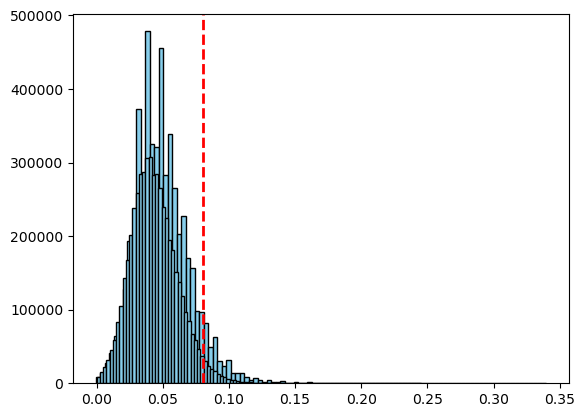

In [66]:
import matplotlib.pyplot as plt
plt.hist(data['ozone_max'], bins=100, color='skyblue', edgecolor='black')
plt.hist(data['epa_8hr'], bins=100, color='skyblue', edgecolor='black')
plt.axvline(x=0.08, color='red', linestyle='--', linewidth=2)

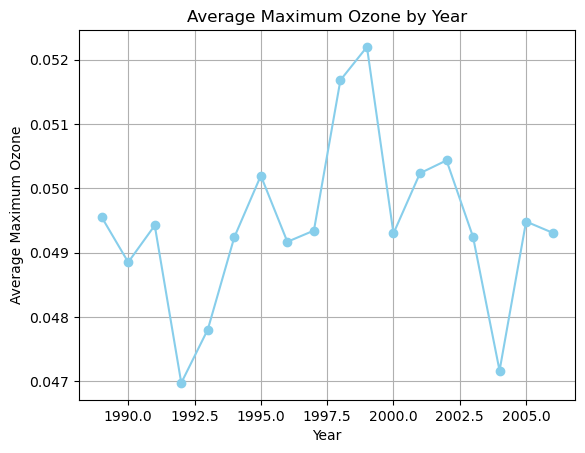

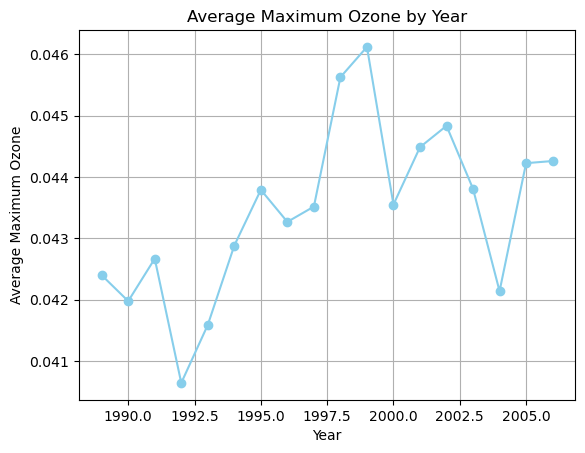

In [67]:
grouped_data = data.groupby('year')['ozone_max'].mean().reset_index()

# Plotting a line graph
plt.plot(grouped_data['year'], grouped_data['ozone_max'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Maximum Ozone')
plt.title('Average Maximum Ozone by Year')
plt.grid(True)  # Add gridlines for better readability
plt.show()

grouped_data = data.groupby('year')['epa_8hr'].mean().reset_index()

# Plotting a line graph
plt.plot(grouped_data['year'], grouped_data['epa_8hr'], marker='o', color='skyblue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Maximum Ozone')
plt.title('Average Maximum Ozone by Year')
plt.grid(True)  # Add gridlines for better readability
plt.show()

In [68]:

# Set memory, processors, and other configurations (not directly equivalent in pandas)
# These configurations are often not necessary in Python, as memory management and parallel processing are typically handled differently.

# Change directory
file_path = "Downloads/112465-V1/AER20090377_DataAndPrograms/"
# There's no direct equivalent to 'cd' in Python, but you can specify the file path when loading the file.

# Load the data
final_data = pd.read_stata("Downloads/AER20090377_FinalData.dta")

# Data preparation
# Keep years before 2004
final_data = final_data[final_data['year'] < 2004]

# Drop rows with invalid observations
final_data = final_data[final_data['valid'] >= 9]

# Keep only Jun-Aug months
final_data = final_data[final_data['month'].isin([6, 7, 8])]

# Keep monitor-years with at least 75% of days with observations
num_days_per_year = final_data.groupby(['fips', 'site_id', 'year']).size().reset_index(name='NumDays')
num_days_per_year = num_days_per_year[num_days_per_year['NumDays'] >= 69]
final_data = final_data.merge(num_days_per_year[['fips', 'site_id', 'year']], on=['fips', 'site_id', 'year'], how='inner')

# Save the filtered data
final_data.to_stata(file_path + "SummerList.dta", write_index=False)


In [69]:
# Drop monitors in untreated counties that border treated counties
neighbor_data = pd.read_stata("Downloads/112465-V1/AER20090377_DataAndPrograms/AER20090377_NeighborData.dta")
neighbor_data = neighbor_data.merge(final_data[['fips', 'site_id', 'year']], on=['fips'], how='inner')

In [70]:
temp_data = final_data
untreated_border_counties = neighbor_data['fips'].unique()
temp_data = temp_data[~temp_data['fips'].isin(untreated_border_counties)]

# Turn off RFG when CARB is on
temp_data.loc[temp_data['treat_CARB'] != 0, 'treat_rfg'] = 0

# Save the modified data
temp_data.to_stata(file_path + "temp.dta", write_index=False)

In [71]:
temp_data['DOW'] = temp_data['Date'].dt.dayofweek
# Generate interaction terms
temp_data.loc[:, '_DMTempMax'] = temp_data['DOW'] * temp_data['TempMax']
temp_data.loc[:, '_DmTempMin'] = temp_data['DOW'] * temp_data['TempMin']
temp_data.loc[:, '_DrRain'] = temp_data['DOW'] * temp_data['Rain']
temp_data.loc[:, '_DsSnow'] = temp_data['DOW'] * temp_data['Snow']

# Generate 'DOY' (day of year)
temp_data.loc[:, 'DOY'] = temp_data['Date'].dt.dayofyear

#Temperature Polynomials
temp_data.loc[:, 'TempMax1'] = temp_data['TempMax']
temp_data.loc[:, 'TempMax2'] = temp_data['TempMax'] * temp_data['TempMax']
temp_data.loc[:, 'TempMax3'] = temp_data['TempMax'] * temp_data['TempMax'] * temp_data['TempMax']
temp_data.loc[:, 'TempMin1'] = temp_data['TempMin']
temp_data.loc[:, 'TempMin2'] = temp_data['TempMin'] * temp_data['TempMin']
temp_data.loc[:, 'TempMin3'] = temp_data['TempMin'] * temp_data['TempMin'] * temp_data['TempMin']
temp_data.loc[:, 'TempMaxMin'] = temp_data['TempMin'] * temp_data['TempMax']
temp_data.loc[:, 'Rain1'] = temp_data['Rain']
temp_data.loc[:, 'Rain2'] = temp_data['Rain'] * temp_data['Rain']
temp_data.loc[:, 'Snow1'] = temp_data['Snow']
temp_data.loc[:, 'Snow2'] = temp_data['Snow'] * temp_data['Snow']
temp_data.loc[:, 'RainTempMax'] = temp_data['Rain'] * temp_data['TempMax']



/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/1805961001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['DOW'] = temp_data['Date'].dt.dayofweek
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/1805961001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data.loc[:, '_DMTempMax'] = temp_data['DOW'] * temp_data['TempMax']
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/1805961001.py:4: SettingWithCopyWarning: 
A value is trying to be se

In [72]:
import numpy as np

temp_data = temp_data.sort_values(by=['fips', 'site_id', 'Date'])
temp_data['TempMaxL1'] = temp_data.groupby(['fips', 'site_id'])['TempMax'].shift(1)
temp_data.loc[temp_data.groupby(['fips', 'site_id'])['TempMaxL1'].head(1).index, 'TempMaxL1'] = np.nan
temp_data['TempMinL1'] = temp_data.groupby(['fips', 'site_id'])['TempMin'].shift(1)
temp_data.loc[temp_data.groupby(['fips', 'site_id'])['TempMinL1'].head(1).index, 'TempMinL1'] = np.nan
temp_data['TempMaxMaxL1'] = temp_data['TempMax'] * temp_data['TempMaxL1']
temp_data['TempMaxMinL1'] = temp_data['TempMax'] * temp_data['TempMinL1']

In [73]:
start_index = temp_data.columns.get_loc('TempMax1')
end_index = temp_data.columns.get_loc('TempMaxMinL1') + 1
for var in temp_data.columns[start_index:end_index]:
    temp_data['DOY' + var] = temp_data['DOY'] * temp_data[var]

# Keep only Jun-Aug
temp_data = temp_data[temp_data['month'].isin([6, 7, 8])]

# Save the modified data
temp_data.to_stata(file_path + "temp.dta", write_index=False)

In [74]:
#Additional variables: income. Take logs of ozone

income_data = pd.read_stata("Downloads/112465-V1/AER20090377_DataAndPrograms/AER20090377_IncomeData.dta")

income_data.head()

,state_code,county_code,year,income
0,1,1,1989,488637.0
1,1,1,1990,513895.0
2,1,1,1991,555815.0
3,1,1,1992,593817.0
4,1,1,1993,629633.0


In [75]:
temp_data.head()

,state_code,county_code,site_id,valid,epa_8hr,ozone_max,day,month,year,Date,...,DOYTempMaxMin,DOYRain1,DOYRain2,DOYSnow1,DOYSnow2,DOYRainTempMax,DOYTempMaxL1,DOYTempMinL1,DOYTempMaxMaxL1,DOYTempMaxMinL1
0,1,1,3,11.0,0.040714,0.047,1.0,6.0,1990.0,1990-06-01,...,807424.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,1,1,3,11.0,0.016714,0.020,2.0,6.0,1990.0,1990-06-02,...,865674.0,3213.0,67473.0,0.0,0.0,263466.0,12699.0,9792.0,1041318.0,802944.0
2,1,1,3,11.0,0.028286,0.034,3.0,6.0,1990.0,1990-06-03,...,966966.0,0.0,0.0,0.0,0.0,0.0,12628.0,10626.0,1149148.0,966966.0
3,1,1,3,9.0,0.035250,0.046,4.0,6.0,1990.0,1990-06-04,...,948600.0,5580.0,200880.0,0.0,0.0,474300.0,14105.0,10695.0,1198925.0,909075.0
4,1,1,3,12.0,0.063750,0.075,5.0,6.0,1990.0,1990-06-05,...,855036.0,0.0,0.0,0.0,0.0,0.0,13260.0,11232.0,1153620.0,977184.0


In [76]:
temp_data.sort_values(by=['state_code', 'county_code', 'year'], inplace=True)

# Merge temp_data with income_data on state_code, county_code, and year
merged_data = pd.merge(temp_data, income_data, on=['state_code', 'county_code', 'year'], how='inner', suffixes=('_temp', '_income'))

merged_data.head()

,state_code,county_code,site_id,valid,epa_8hr,ozone_max,day,month,year,Date,...,DOYRain1,DOYRain2,DOYSnow1,DOYSnow2,DOYRainTempMax,DOYTempMaxL1,DOYTempMinL1,DOYTempMaxMaxL1,DOYTempMaxMinL1,income
0,1,1,3,11.0,0.040714,0.047,1.0,6.0,1990.0,1990-06-01,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,513895.0
1,1,1,3,11.0,0.016714,0.020,2.0,6.0,1990.0,1990-06-02,...,3213.0,67473.0,0.0,0.0,263466.0,12699.0,9792.0,1041318.0,802944.0,513895.0
2,1,1,3,11.0,0.028286,0.034,3.0,6.0,1990.0,1990-06-03,...,0.0,0.0,0.0,0.0,0.0,12628.0,10626.0,1149148.0,966966.0,513895.0
3,1,1,3,9.0,0.035250,0.046,4.0,6.0,1990.0,1990-06-04,...,5580.0,200880.0,0.0,0.0,474300.0,14105.0,10695.0,1198925.0,909075.0,513895.0
4,1,1,3,12.0,0.063750,0.075,5.0,6.0,1990.0,1990-06-05,...,0.0,0.0,0.0,0.0,0.0,13260.0,11232.0,1153620.0,977184.0,513895.0


In [77]:
# Drop rows where ozone_max or epa_8hr is equal to 0
merged_data = merged_data[(merged_data['ozone_max'] != 0) & (merged_data['epa_8hr'] != 0)]

# Drop rows where any of the TempMax1-TempMax3 or TempMin1-TempMin3 variables is missing
temp_max_vars = [f"TempMax{i}" for i in range(1, 4)]
temp_min_vars = [f"TempMin{i}" for i in range(1, 4)]
merged_data = merged_data.dropna(subset=temp_max_vars + temp_min_vars)

# Drop rows where income is missing
merged_data = merged_data.dropna(subset=['income'])

merged_data['lozone_max'] = np.log10(merged_data['ozone_max'])
merged_data['lozone_8hr'] = np.log10(merged_data['epa_8hr'])


In [78]:
#Create census region dummies and interactions. Create time trend and interactions

merged_data['region'] = np.nan
merged_data['division'] = np.nan



In [79]:
state_region_mapping = {
    1: 3, 2: 4, 4: 4, 5: 3, 6: 4, 8: 4, 9: 1, 10: 3, 11: 3, 12: 3,
    13: 3, 15: 4, 16: 4, 17: 2, 18: 2, 19: 2, 20: 2, 21: 3, 22: 3, 23: 1,
    24: 3, 25: 1, 26: 2, 27: 2, 28: 3, 29: 2, 30: 4, 31: 2, 32: 4, 33: 1,
    34: 1, 35: 4, 36: 1, 37: 3, 38: 2, 39: 2, 40: 3, 41: 4, 42: 1, 44: 1,
    45: 3, 46: 2, 47: 3, 48: 3, 49: 4, 50: 1, 51: 3, 53: 4, 54: 3, 55: 2, 56: 4
}

# Update the 'region' column based on the state_code
merged_data.loc[merged_data['state_code'] == 1, 'region'] = 3
merged_data.loc[merged_data['state_code'] == 2, 'region'] = 4
# Repeat the above line for each state_code and corresponding region using the state_region_mapping dictionary

# You can also use a loop to iterate over the state_region_mapping dictionary
for state_code, region in state_region_mapping.items():
    merged_data.loc[merged_data['state_code'] == state_code, 'region'] = region
    

In [80]:
merged_data.loc[:, '_RY'] = merged_data['year']*merged_data['region']
merged_data.loc[:, '_RW'] = merged_data['DOW']*merged_data['region']
merged_data.loc[:, '_RD'] = merged_data['DOY']*merged_data['region']
merged_data['DateS'] = merged_data['Date'].dt.dayofyear / 365
merged_data['DateS2'] = (merged_data['DateS'])**2

In [81]:
# Drop the specified columns (commented out on repeat)
merged_data.drop(columns=['RVPCty', 'RFGCty', 'CARBCty'], inplace=True)

# Group by 'fips' and create new variables 'RVPCty' and 'RFGCty' within each group
merged_data['RVPCty'] = merged_data.groupby('fips')['treat_rvpII'].transform('max')
merged_data['RFGCty'] = merged_data.groupby('fips')['treat_rfg'].transform('max')


In [82]:
merged_data.loc[:, 'RVPRFGCty'] = 0
# Replace RVPRFGCty with 1 where both RFGCty and RVPCty are equal to 1
merged_data.loc[(merged_data['RFGCty'] == 1) & (merged_data['RVPCty'] == 1), 'RVPRFGCty'] = 1

# Replace RFGCty with 0 where RVPRFGCty is equal to 1
merged_data.loc[merged_data['RVPRFGCty'] == 1, 'RFGCty'] = 0

# Replace RVPCty with 0 where RVPRFGCty is equal to 1
merged_data.loc[merged_data['RVPRFGCty'] == 1, 'RVPCty'] = 0

In [83]:
# Assuming merged_data is a pandas DataFrame
merged_data['CARBCty'] = merged_data.groupby('fips')['treat_CARB'].transform('max')
merged_data.loc[:, 'CARBRFGCty'] = 0

# Replace CARBRFGCty with 1 if either RFGCty or RVPRFGCty is 1 and CARBCty is 1
merged_data['CARBRFGCty'] = ((merged_data['RFGCty'] == 1) | (merged_data['RVPRFGCty'] == 1)) & (merged_data['CARBCty'] == 1)

# Replace RFGCty with 0 if CARBRFGCty is 1

merged_data.loc[merged_data['CARBRFGCty'] == 1, 'RFGCty'] = 0

merged_data.loc[merged_data['CARBRFGCty'] == 1, 'RVPRFGCty'] = 0

merged_data.loc[merged_data['CARBRFGCty'] == 1, 'CARBCty'] = 0

In [84]:
for i in range(1, 5):
    merged_data[f'TrendRVP{i}'] = 0
    merged_data.loc[(merged_data['RVPCty'] == 1) & (merged_data['region'] == i), f'TrendRVP{i}'] = merged_data['DateS']
for i in range(1, 5):
    merged_data[f'TrendRFG{i}'] = 0
    merged_data.loc[(merged_data['RFGCty'] == 1) & (merged_data['region'] == i), f'TrendRFG{i}'] = merged_data['DateS']
for i in range(1, 5):
    merged_data[f'TrendRVPRFG{i}'] = 0
    merged_data.loc[(merged_data['RVPRFGCty'] == 1) & (merged_data['region'] == i), f'TrendRVPRFG{i}'] = merged_data['DateS']
for i in range(1, 5):
    merged_data[f'TrendCARB{i}'] = 0
    merged_data.loc[(merged_data['CARBCty'] == 1) & (merged_data['region'] == i), f'TrendCARB{i}'] = merged_data['DateS']  
for i in range(1, 5):
    merged_data[f'TrendCARBRFG{i}'] = 0
    merged_data.loc[(merged_data['CARBRFGCty'] == 1) & (merged_data['region'] == i), f'TrendCARBRFG{i}'] = merged_data['DateS']    

In [85]:
for i in range(1, 5):
    merged_data[f'QTrendRVP{i}'] = 0
    merged_data.loc[(merged_data['RVPCty'] == 1) & (merged_data['region'] == i), f'QTrendRVP{i}'] = merged_data['DateS']**2

for i in range(1, 5):
    merged_data[f'QTrendRFG{i}'] = 0
    merged_data.loc[(merged_data['RFGCty'] == 1) & (merged_data['region'] == i), f'QTrendRFG{i}'] = merged_data['DateS']**2
    
for i in range(1, 5):
    merged_data[f'QTrendRVPRFG{i}'] = 0
    merged_data.loc[(merged_data['RVPRFGCty'] == 1) & (merged_data['region'] == i), f'QTrendRVPRFG{i}'] = merged_data['DateS']**2
    
for i in range(1, 5):
    merged_data[f'QTrendCARB{i}'] = 0
    merged_data.loc[(merged_data['CARBCty'] == 1) & (merged_data['region'] == i), f'QTrendCARB{i}'] = merged_data['DateS']**2
    
for i in range(1, 5):
    merged_data[f'QTrendCARBRFG{i}'] = 0
    merged_data.loc[(merged_data['CARBRFGCty'] == 1) & (merged_data['region'] == i), f'QTrendCARBRFG{i}'] = merged_data['DateS']**2


In [86]:
# Sort the DataFrame by 'state_code' and 'year'
merged_data.sort_values(by=['state_code', 'year'], inplace=True)

# Generate a new variable 'StateYear' based on grouping by 'state_code' and 'year'
merged_data['StateYear'] = merged_data.groupby(['state_code', 'year']).ngroup()

# Save the DataFrame to a file
merged_data.to_stata('DD_AnalysisDataset_NYR.dta', write_index=False, convert_dates={'Date': 'td'})


In [87]:
#The REGRESSION!

#Step one is to first-difference everything on panelid

# Mean-difference all variables on panelid
merged_data['A_fips'] = merged_data['fips']
merged_data['A_month'] = merged_data['month']
merged_data['A_year'] = merged_data['year']
merged_data['A_StateYear'] = merged_data['StateYear']
merged_data['A_StateCode'] = merged_data['state_code']
merged_data['A_EstTemp'] = merged_data['EstTempFlag']
merged_data['A_EstTempPrcp'] = merged_data['EstTempFlagprcp']

# Keep selected columns
merged_data = merged_data.filter(regex='^lozone_|^treat|^Temp|^Rain|^Snow|^DOY|^Trend|^QTrend|^DateS|_D|_R|income|panelid|^A_')

# Sort by panelid
merged_data.sort_values(by='panelid', inplace=True)


In [88]:
 import re

# Define variable patterns
variable_patterns = ['lozone_', 'treat', 'Temp', 'Rain', 'Snow', 'DOY', 'Trend', 'QTrend', 'DateS', '_D', '_R', 'income']

# List to store generated columns
generated_columns = []

# Iterate over variable patterns
for pattern in variable_patterns:
    # Filter columns based on pattern
    relevant_columns = merged_data.filter(regex=f'^{pattern}').columns
    
    # Calculate mean by panelid for relevant columns
    means = merged_data.groupby('panelid')[relevant_columns].transform('mean')
    
    # Generate differenced variables
    for col in relevant_columns:
        # Generate the differenced variable
        diff_col = f"{col}D"
        merged_data[diff_col] = merged_data[col] - means[col]
        generated_columns.append(diff_col)

# Drop original and mean columns
merged_data.drop(columns=merged_data.filter(like='M').columns, inplace=True)

# Save to a new file
merged_data.to_stata('DD_AnalysisDataset_Diffed_NYR.dta', write_index=False)


/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[diff_col] = merged_data[col] - means[col]
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[diff_col] = merged_data[col] - means[col]
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[diff_col] = merged_data[col] - means[col]
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[diff_col] = merged_data[col] - means[col]
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[diff_col] = merged_data[col] - means[col]
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[diff_col] = merged_data[col] - means[col]
/var/folders/sb/wkgkxhms7671rqjklclt6qlh0000gn/T/ipykernel_12400/4166208684.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [91]:
merged_data['lozone_maxD']

63         0.022616
32         0.022616
33        -0.063744
34        -0.046710
35         0.000714
             ...   
1144143    0.024778
1144144   -0.006821
1144145    0.088448
1144138    0.114002
1144555    0.017092
Name: lozone_maxD, Length: 1144263, dtype: float32

In [98]:
#EPA Ozone Max Emissions

#Regression 1

# Define independent and dependent variables
X = merged_data.filter(regex='^treat').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

In [99]:
#Regression 2

# Define independent and dependent variables
X = merged_data.filter(regex='^treat|_RY').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality 
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

In [100]:
#Regression 3

# Define independent and dependent variables
X = merged_data.filter(regex='^treat|_R').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

In [104]:
#Regression 4

# Define independent and dependent variables
X = merged_data.filter(regex='^treat|Temp|Rain|Snow|DOY|_D|_R').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

merged_data.dropna(subset=['lozone_maxD'] + list(X.columns), inplace=True)

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

/Users/safiaread/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 42, but rank is 33
  warnings.warn('covariance of constraints does not have full '


In [105]:
#Regression 5


# Define independent and dependent variables
X = merged_data.filter(regex='^treat|income|Temp|Rain|Snow|DOY|_D|_R').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

merged_data.dropna(subset=['lozone_maxD'] + list(X.columns), inplace=True)

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

In [106]:
#Regression 6



# Define independent and dependent variables
X = merged_data.filter(regex='^treat|income|Trend|Temp|Rain|Snow|DOY|_D|_R').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

merged_data.dropna(subset=['lozone_maxD'] + list(X.columns), inplace=True)

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

In [107]:
#Regression 7

# Define independent and dependent variables
X = merged_data.filter(regex='^treat|income|Trend|QTrend|Temp|Rain|Snow|DOY|_D|_R').copy()  # Independent variables
y = merged_data['lozone_maxD']  # Dependent variable

merged_data.dropna(subset=['lozone_maxD'] + list(X.columns), inplace=True)

# Perform regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})

# Print regression summary
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.summary().as_text() + '\n\n')  # Append results to text file

# Test parameter equality
hypotheses = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model.t_test(hypotheses).summary().as_text() + '\n\n')  # Append results to text file

In [ ]:
import statsmodels.api as sm

# Define hypotheses for parameter equality tests
hypotheses1 = 'treat_rvpIID = treat_rfgD, treat_rvpIID = treat_CARBD, treat_rfgD = treat_CARBD'

# Regression 1: Base regression
X1 = merged_data.filter(regex='^treat').copy()
y1 = merged_data['lozone_8hrD']
model1 = sm.OLS(y1, X1).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model1.t_test(hypotheses1).summary().as_text() + '\n\n')

# Regression 2: Adding year * region FE
X2 = merged_data.filter(regex='^treat|_RY').copy()
y2 = merged_data['lozone_8hrD']
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model2.t_test(hypotheses1).summary().as_text() + '\n\n')

# Regression 3: Adding DOY and DOW controls
X3 = merged_data.filter(regex='^treat|_R').copy()
y3 = merged_data['lozone_8hrD']
model3 = sm.OLS(y3, X3).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model3.t_test(hypotheses1).summary().as_text() + '\n\n')

# Regression 4: Adding weather and weather cross effects
X4 = merged_data.filter(regex='^treat|Temp|Rain|Snow|DOY|_D|_R').copy()
y4 = merged_data['lozone_8hrD']
merged_data.dropna(subset=['lozone_8hrD'] + list(X4.columns), inplace=True)
model4 = sm.OLS(y4, X4).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model4.t_test(hypotheses1).summary().as_text() + '\n\n')

# Regression 5: Adding income
X5 = merged_data.filter(regex='^treat|income|Temp|Rain|Snow|DOY|_D|_R').copy()
y5 = merged_data['lozone_8hrD']
merged_data.dropna(subset=['lozone_8hrD'] + list(X5.columns), inplace=True)
model5 = sm.OLS(y5, X5).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model5.t_test(hypotheses1).summary().as_text() + '\n\n')

# Regression 6: Adding linear trends
X6 = merged_data.filter(regex='^treat|income|Trend|Temp|Rain|Snow|DOY|_D|_R').copy()
y6 = merged_data['lozone_8hrD']
merged_data.dropna(subset=['lozone_8hrD'] + list(X6.columns), inplace=True)
model6 = sm.OLS(y6, X6).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model6.t_test(hypotheses1).summary().as_text() + '\n\n')

# Regression 7: Adding quadratic trends
X7 = merged_data.filter(regex='^treat|income|Trend|QTrend|Temp|Rain|Snow|DOY|_D|_R').copy()
y7 = merged_data['lozone_8hrD']
merged_data.dropna(subset=['lozone_8hrD'] + list(X7.columns), inplace=True)
model7 = sm.OLS(y7, X7).fit(cov_type='cluster', cov_kwds={'groups': merged_data['A_StateYear']})
with open('DDResults_NYR.txt', 'a') as f:
    f.write(model7.t_test(hypotheses1).summary().as_text() + '\n\n')


In [2]:
import pandas as pd

# Load dataset
data = pd.read_stata("DD_AnalysisDataset_NYR.dta")

# Display yearly observation count
print(data['year'].value_counts())

# Remove duplicates
data = data.drop_duplicates(subset=['year', 'panelid', 'urban'])

# Display yearly observation count after removing duplicates
print(data['year'].value_counts())

# Keep only specific variables
data = data[['state_code', 'county_code', 'year', 'treat_rvpII', 'treat_rvpI', 'treat_rfg', 'treat_CARB']]

# Collapse dataset
data = data.groupby(['state_code', 'county_code', 'year']).max().reset_index()

# Display yearly observation count for each treatment type
counts_dict = {
    'treat_rvpI': data[data['treat_rvpI'] == 1]['year'].value_counts(),
    'treat_rvpII': data[data['treat_rvpII'] == 1]['year'].value_counts(),
    'treat_rfg': data[data['treat_rfg'] == 1]['year'].value_counts(),
    'treat_CARB': data[data['treat_CARB'] == 1]['year'].value_counts()
}

# Convert the dictionary to a DataFrame
counts_df = pd.DataFrame(counts_dict)

# Fill NaN values with zeros
counts_df = counts_df.fillna(0)

# Print the DataFrame
print(counts_df)


year
2003.0    85261
2002.0    85231
2001.0    83788
2000.0    82469
1999.0    80755
1998.0    79676
1997.0    78286
1995.0    77025
1996.0    76471
1994.0    74449
1993.0    72620
1992.0    69855
1991.0    69174
1990.0    66119
1989.0    63084
Name: count, dtype: int64
year
2003.0    945
2002.0    943
2001.0    929
2000.0    915
1999.0    899
1998.0    889
1997.0    873
1995.0    865
1996.0    854
1994.0    835
1993.0    815
1992.0    789
1991.0    782
1990.0    751
1989.0    720
Name: count, dtype: int64
        treat_rvpI  treat_rvpII  treat_rfg  treat_CARB
year                                                  
1989.0       371.0          0.0        0.0         0.0
1990.0       381.0          0.0        0.0         0.0
1991.0       395.0          0.0        0.0         0.0
1992.0         0.0        132.0        0.0         0.0
1993.0         0.0        140.0        0.0         0.0
1994.0         0.0        140.0        0.0         0.0
1995.0         0.0        111.0      111.0      